# カギ足の描画

出典1：plot a kagi chart using python not JavaScript or other code

https://stackoverfLow.com/questions/75027757/plot-a-kagi-chart-using-python-not-javascript-or-other-code

出典2：Matplotlib 時系列データの軸設定｜自由に時間軸を設定！

https://www.yutaka-note.com/entry/matplotlib_time_axis

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np
from pandas_datareader import data as pdr
import matplotlib.dates as mdates

## 株価データの取得

In [2]:
# Define the stock symbol and timeframe
symbol = '8996.T' 
end_date = datetime.today()
start_date = end_date - timedelta(days=180)  # 6 months before today
yf.pdr_override()
# yahooサイトからデータをダウンロード
stock_data = pdr.get_data_yahoo(symbol, start_date, end_date)
stock_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-14,725.0,725.0,721.0,721.0,721.0,700
2023-06-15,723.0,724.0,718.0,724.0,724.0,6800
2023-06-16,724.0,726.0,724.0,724.0,724.0,2000
2023-06-19,725.0,725.0,720.0,723.0,723.0,3000
2023-06-20,724.0,724.0,719.0,721.0,721.0,3900


## カギ足のためのデータ準備の関数

In [3]:
def KagiChart(df,delta):
    # カギ足描画のためのデータフレームの初期化
    kagi_df = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Extreme', 'Direc'])

    # データの出発点における設定
    trend = 0
    kagi = df.iloc[0]['Close']
    kagi_df.loc[0] = [df.iloc[0]['Date'], df.iloc[0]['Open'], df.iloc[0]['High'], df.iloc[0]['Low'],
                      df.iloc[0]['Close'], df.iloc[0]['Volume'], df.iloc[0]['Close'], 'Line']

    # 2行目以降のデータの扱い
    m = df.shape[0] - 1
    k = 1
    for i in range(1, m):
        # 下降トレンド中で価格変化が上昇反転ルールを満たした場合
        if trend <= 0 and df.iloc[i]['Close'] > kagi+delta:
            kagi_df.loc[k] = [df.iloc[i]['Date'], df.iloc[i]['Open'], df.iloc[i]['High'], df.iloc[i]['Low'],
                              df.iloc[i]['Close'], df.iloc[i]['Volume'], kagi, 'up']
            kagi = df.iloc[i]['Close']
            trend = 1
            k += 1
        # 上昇トレンド中で価格変化が下降反転ルールを満たした場合
        elif trend >= 0 and df.iloc[i]['Close'] < kagi-delta:
            kagi_df.loc[k] = [df.iloc[i]['Date'], df.iloc[i]['Open'], df.iloc[i]['High'], df.iloc[i]['Low'],
                              df.iloc[i]['Close'], df.iloc[i]['Volume'], kagi, 'down']
            kagi = df.iloc[i]['Close']
            trend = -1
            k += 1
        # 下降トレンド中で引き続き下降を示した場合
        elif trend <= 0 and df.iloc[i]['Close'] <= kagi:
            kagi = df.iloc[i]['Close']
        # 上昇トレンド中で引き続き上昇を示した場合
        elif trend >= 0 and df.iloc[i]['Close'] >= kagi:
            kagi = df.iloc[i]['Close']
        # 上記以外の場合は何もしない
        
    # データの最終行における設定
    kagi_df.loc[k] = [df.iloc[m]['Date'], df.iloc[m]['Open'], df.iloc[m]['High'], df.iloc[m]['Low'],
                      df.iloc[m]['Close'], df.iloc[m]['Volume'], df.iloc[m]['Close'], 'End']
    return kagi_df

## カギ足チャートの描画

         Date   Open   High    Low  Close  Volume  Extreme Direc
5  2023-08-24  752.0  754.0  752.0  754.0    1300    743.0    up
6  2023-09-19  865.0  865.0  829.0  849.0   20500    869.0  down
7  2023-09-25  845.0  856.0  842.0  856.0    2800    843.0    up
8  2023-10-03  860.0  874.0  850.0  851.0    7300    870.0  down
9  2023-10-05  835.0  860.0  835.0  853.0    3200    829.0    up
10 2023-10-11  869.0  869.0  835.0  835.0    3100    869.0  down
11 2023-10-13  833.0  845.0  833.0  837.0    2100    826.0    up
12 2023-11-06  869.0  869.0  840.0  840.0   18000    866.0  down
13 2023-11-10  839.0  839.0  828.0  832.0    4900    821.0    up
14 2023-12-11  980.0  980.0  946.0  958.0   26400    958.0   End


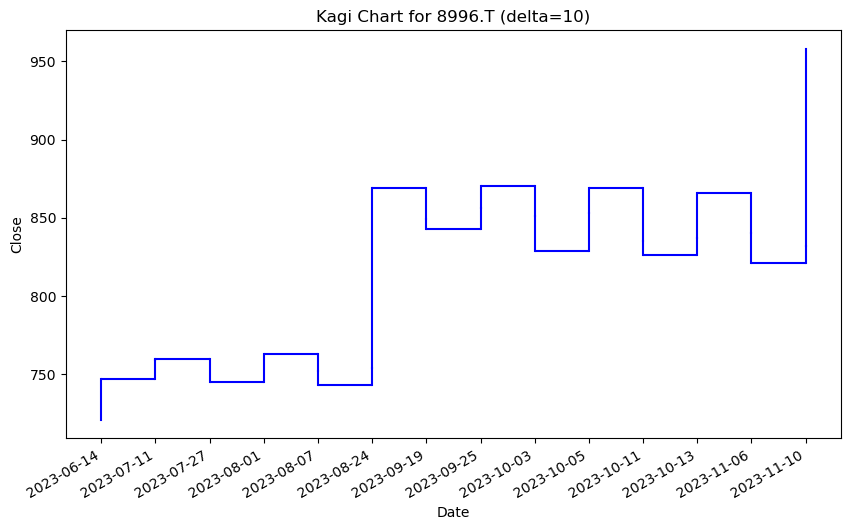

In [4]:
# 株価データの準備
df = stock_data.copy().reset_index()
delta = 10 # 反転基準価格差の設定
df_kagi = KagiChart(df,delta)
print(df_kagi.tail(10))
Date = df_kagi['Date']
Close = df_kagi['Close']
extreme = df_kagi['Extreme']
direction = df_kagi['Direc']
# X軸変数として用いるインデックスの生成
indices = range(len(Date))
fig, ax = plt.subplots(figsize =(10,6))
# 軸目盛には日付を対応させる
plt.xticks(indices, [date.strftime('%Y-%m-%d') for date in Date])
fig.autofmt_xdate()
# 上又は下方向の垂直線を描画し、同じくその起点から左方向へ水平線を描画し、一つ前の時点で垂直線を付け足す
for i in range(1,len(Date)):
    if direction[i] == 'Line':
        ax.plot([indices[i], indices[i]], [extreme[i], Close[i]], color='b')
    elif direction[i] == 'End':
        ax.plot([indices[i-1], indices[i-1]], [extreme[i], Close[i-1]], color='b')
    elif direction[i] == 'up':
        ax.plot([indices[i], indices[i]], [extreme[i], Close[i]], color='b')
        ax.plot([indices[i-1], indices[i-1]], [extreme[i], Close[i-1]], color='b')
        plt.hlines(extreme[i], xmin=indices[i-1], xmax=indices[i], color='b')
    else:
        ax.plot([indices[i], indices[i]], [extreme[i], Close[i]], color='b')
        ax.plot([indices[i-1], indices[i-1]], [extreme[i], Close[i-1]], color='b')
        plt.hlines(extreme[i], xmin=indices[i-1], xmax=indices[i],color='b')
# グラフタイトルと軸ラベルを設定する
ax.set_title('Kagi Chart for '+symbol+' (delta='+str(delta)+')')
ax.set_xlabel('Date')
ax.set_ylabel('Close')
plt.show()